Predicting future stock price movement is known difficult due to low signal-to-noise ratio and non stationary price distribution. Off-the-shelf successful ML algorithms often give you disappointed results. Due to this difficulty, a lot of ML quant hedge funds shows up and disappear every year. 

![southpark_finance](https://media.giphy.com/media/3o6ZtiGv3tTlXTsWli/giphy.gif)

In order to combat this situation, we need to formalize the problem more carefully. In this article, we focus on considering how to label data and set up supervised learning. Most approaches here are based on a recently published book, `Advances in Financial Machine Learning`[[1]](https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089). I highly recommend you to check it for more detail.



#### Spoiler Alert!
The result itself is not impressive. We just go through the basic way to formalize the problem. I will write about how to validate model and hyperparameter tuning to improve the performance in a different blog post. 

# Classification Approach

Predicting the direction of stock prices are frequently used to make signals for algorithm trading. This task is formalized as classification, where classifiers predict if the future price goes up or down. The resultant outputs of classifiers can be fed into trading algorithms as signals, e.g., buying(selling) a stock when the prediction is positive(negative). To treat the task as classification, we need to get labels according to the future price. One of the common approaches I have seen a lot is simply labeling with  next date price direction. Labels getting through this approach may be contaminated by noise due to low signal-to-noise ratio, i.e., strong noise compared to signal.

For example, even if the next date return distribution has positive mean, the price may end up going downward due to the noise. Let's see this from more mathematical perspective. 

Let $P_n$ and $P_0$ be n date forward and current stock price. They are related through the following equation:

$$P_n = P_0 \prod_{i=1}^N (1 + r_i)$$
, where $r_i$ is return for each date.

If $r_i << 1$, $\forall i$, we approximate this relation by
$$P_n \sim P_0 (1 + \sum_{i=1}^n r_i)$$

If all returns are sampled according to the same normal distribution distribution, i.e., $r_i \sim N(\mu, \sigma), \forall i$,
$$\sum_{i=1}^N r_i \sim N(n\mu, \sqrt{n} \sigma)$$.

Thus, mean value grows faster than standard deviation.
This result implies that labeling price with further future gives you more reliable labels.
For example, consider the case where mean is positive. We want to label the direction positive up to one standard deviation. In order to achieve this, we need to take n such that

$$n \mu \geq \sqrt{n} \sigma$$
$$ n \geq (\frac{\sigma}{\mu})^2$$

If we use n larger than the square of noise ratio, the price direction will be labeled correctly with about 84 percent.

## Synthetic Data
Let's see the above statement of above discussion in a synthetic data.

In [1]:
import numpy as np

mu = 0.1
sig = 1.
N = 400
n_samples = 1000
x = np.arange(N)
samples = []
for i in range(n_samples):
    rs = np.random.normal(mu, sig, N)
    rs = np.cumsum(rs)
    samples.append(rs)
samples = np.array(samples)
r_mu = np.mean(samples, axis=0)
r_sig = np.std(samples, axis=0)

We consider the example where mean is 0.1 and standard deviation is 1.0. Since the signal-to-noise ratio is 10, We can deduce that 100 steps are required to get reliable labels.

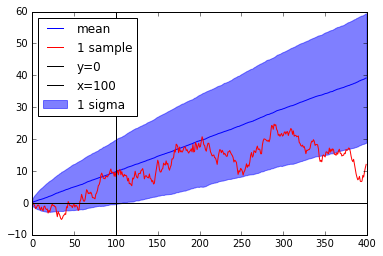

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, r_mu, label='mean', color='b');
plt.plot(x, samples[0], label='1 sample', color='r')
plt.plot(x, 0 * x, label='y=0', color='k');
plt.axvline(x=100, label='x=100', color='k')
plt.fill_between(x, r_mu + r_sig, r_mu - r_sig, color='b', alpha=.5, label='1 sigma');
plt.legend(loc='upper left');
plt.savefig('synthetic.png')

As we expected, points within one standard deviation resides in positive area after 100 steps. Before 100 steps, the points are highly likely to end up sitting on negative area. If you label data point with short term forward points, you may get wrong labels.

##  Labeling
If the above statement is applicable to actual stock price data, let's label data with 10 years forward price! 
Does this make sense? The answer is probably no. One of the main differences between actual stock price and the synthetic data is stationarity of the distribution. The price distribution is always changing along with the market condition. How far forward price you use would be trade-off between reliability and consistency. This length has to be tuned as a hyperparameter of your algorithms. Although we do not discuss here how to validate model performance correctly and tune hyperparameters, we will go through the way to implement a strategy of labeling stock price data. 

As an example, we play with MicroSoft daily stock price data.

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

symbol = 'MSFT'
path = f'../datasets/US_stocks/{symbol}.csv' 
df = pd.read_csv(path)
df_ = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df_.index = pd.DatetimeIndex(df['Date'])
df_.columns = ['Open', f'High', f'Low', f'Close', f'Volume']
df = df_.dropna()

start = '2000-01-01'
df = df.loc[df.index >= start]

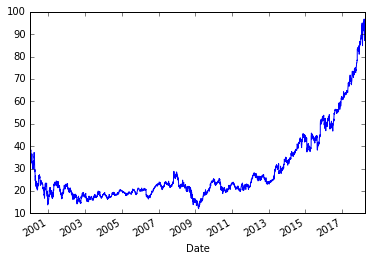

In [4]:
%matplotlib inline

close = df['Close']
close.plot()
plt.savefig('MSFT.png')

In `Advances in Financial Machine Learning`[[1]](https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089), the author suggests `triple barrier method`. He set up labeling with the two horizontal and the one vertical barriers. The horizontal barriers define what price level would be classified as positive or negative while the vertical barrier set how long you look further at maximum for labeling. More precisely, each data point is labeled by the first barrier hit by the future price.

The implementation is based on Chapter 3 of `Advances in Financial Machine Learning`. Some implementation is omitted for the sake of simplicity. Please check out my repository[[2]](https://github.com/jjakimoto/finance_ml) for the fully implementation,.

First, we set up the vertical barrier.

In [5]:
def get_t1(close, timestamps, num_days):
    """Return horizontal timestamps

    Note
    ----
    Not include the case to hit the vertical line at the end of close.index

    Parameters
    ----------
    close: pd.Series
    timestamps: pd.DatetimeIndex
    num_days: int
        The number of forward dates for vertical barrier

    Returns
    -------
    pd.Series: Vertical barrier timestamps
    """
    t1 = close.index.searchsorted(timestamps + pd.Timedelta(days=num_days))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=timestamps[:t1.shape[0]])
    return t1

In [6]:
# We use all data points in this article
timestamps = close.index
num_days = 10
t1 = get_t1(close, timestamps, num_days)
print(t1.head())

Date
2000-01-03   2000-01-13
2000-01-04   2000-01-14
2000-01-05   2000-01-18
2000-01-06   2000-01-18
2000-01-07   2000-01-18
Name: Date, dtype: datetime64[ns]


Each point define what timestamp is defined as the vertical barrier. 

To define the horizontal barriers, we need another two parameters. One of them is `trgt`, which defines the scale of barrier width. The basic idea is that we need to change the width of barriers depending on market conditions. For example, if we are facing a volatile market, we need to use a wide width. you can use daily volatilities to set `trgt`. The daily volatilities are estimated through exponential moving average.

The other parameter is stop loss and take profit. These parameters give you flexibility to define the width of barriers depending on your preference. The positive(negative) label barrier is defined by `Take Profit(Stop Loss) Parameter` times `trgt`.

In [7]:
def get_touch_idx(close, events, sltp, molecule=None):
    """Return timestamps of when data points touch the barriers

    Parameters
    ----------
    close: pd.Series
        Close price series
    events: pd.DataFrame with columns: 't1', 'trgt', and 'side'
        t1: time stamp of vertical barrier, could be np.nan
        trgt: unit of width of horizontal barriers
        side: Side label for metalabeling
    sltp: list
        Coefficients of width of Stop Loss and Take Profit.
        sltp[0] and sltp[1] correspond to width of stop loss
        and take profit, respectively. If 0 or negative, the barrier
        is siwthced off.
    molecule: list, optional
        Subset of indices of events to be processed

    Returns
    -------
    pd.DataFrame: each colum corresponds to the time to touch the barrier
    """
    # Sample a subset with specific indices
    if molecule is not None:
        _events = events.loc[molecule]
    else:
        _events = events
    touch_idx = pd.DataFrame(index=_events.index)
    # Set Stop Loss and Take Profoit
    if sltp[0] > 0:
        sls = -sltp[0] * _events["trgt"]
    else:
        # Switch off stop loss
        sls = pd.Series(index=_events.index)
    if sltp[1] > 0:
        tps = sltp[1] * _events["trgt"]
    else:
        # Switch off profit taking
        tps = pd.Series(index=_events.index)
    # Replace undefined value with the last time index
    vertical_lines = _events["t1"].fillna(close.index[-1])
    for loc, t1 in vertical_lines.iteritems():
        df = close[loc:t1]
        # Change the direction depending on the side
        df = (df / close[loc] - 1) * _events.at[loc, 'side']
        touch_idx.at[loc, 'sl'] = df[df < sls[loc]].index.min()
        touch_idx.at[loc, 'tp'] = df[df > tps[loc]].index.min()
    touch_idx['t1'] = _events['t1'].copy(deep=True)
    return touch_idx

`get_touch_idx` mainly get when and what kind of barriers the future price hit. 

In [8]:
import pandas as pd
from finance_ml.multiprocessing import mp_pandas_obj
LONG = 1
SHORT = -1


def get_events(close, timestamps, sltp, trgt, min_ret=0,
               num_threads=1, t1=None, side=None):
    """Return DataFrame containing infomation defining barriers

    Parameters
    ----------
    close: pd.Series
        Close price series
    timestamps: pd.DatetimeIndex
        sampled points to analyze
    sltp: list
        Coefficients of width of Stop Loss and Take Profit.
        sltp[0] and sltp[1] correspond to width of stop loss
        and take profit, respectively. If 0 or negative, the barrier
        is siwthced off.
    trgt: pd.Series
        Time series of threashold
    min_ret: float, (default 0)
        Minimum value of points to label
    num_threads: int, (default 1)
        The number of threads to use
    t1: pd.Series, optional
        Vertical lines
    side: pd.Series, optional
        Side of trading positions

    Returns
    -------
    pd.DataFrame with columns: 't1', 'trgt', 'type', and 'side'
    """
    # Get sampled target values
    trgt = trgt.loc[timestamps]
    trgt = trgt[trgt > min_ret]
    if len(trgt) == 0:
        return pd.DataFrame(columns=['t1', 'trgt', 'side'])
    # Get time boundary t1
    if t1 is None:
        t1 = pd.Series(pd.NaT, index=timestamps)
    # slpt has to be either of integer, list or tuple
    if isinstance(sltp, list) or isinstance(sltp, tuple):
        _sltp = sltp[:2]
    else:
        _sltp = [sltp, sltp]
    # Define the side
    if side is None:
        # Default is LONG
        _side = pd.Series(LONG, index=trgt.index)
    else:
        _side = side.loc[trgt.index]
    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': _side}, axis=1)
    events = events.dropna(subset=['trgt'])
    time_idx = mp_pandas_obj(func=get_touch_idx,
                             pd_obj=('molecule', events.index),
                             num_threads=num_threads,
                             close=close, events=events, sltp=_sltp)
    # Skip when all of barrier are not touched
    time_idx = time_idx.dropna(how='all')
    events['type'] = time_idx.idxmin(axis=1)
    events['t1'] = time_idx.min(axis=1)
    if side is None:
        events = events.drop('side', axis=1)
    return events

In [9]:
from finance_ml.stats import get_daily_vol
vol = get_daily_vol(close)
print('volatility')
print(vol.head())

events = get_events(close, timestamps, [2, 2], vol, min_ret=0,
                    num_threads=16, t1=t1, side=None)
print('events')
print(events.head())

volatility
Date
2000-01-04         NaN
2000-01-05    0.031374
2000-01-06    0.025522
2000-01-10    0.024588
2000-01-11    0.022054
Name: Close, dtype: float64


/home/tom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


events
                   t1      trgt type
Date                                
2000-01-05 2000-01-12  0.031374   sl
2000-01-06 2000-01-18  0.025522   t1
2000-01-10 2000-01-12  0.024588   sl
2000-01-11 2000-01-18  0.022054   tp
2000-01-12 2000-01-14  0.020946   tp


2018-09-21 18:16:13.911362 100.0% get_touch_idx done after 0.03 minutes. Remaining 0.0 minutes.


`get_events` uses `get_torch_idx` internally and obtain labels.

Output, `events`, contains the followings:
- `t1`, when the barrier is touched
- `trgt`, scale used to define horizontal barrier
- `type`, which barrier is touched


Next, we define `get_sizes`, which generates numerical labels using `events`.
When labeling points hitting the vertical barrier, there are two possible choices. One of them is assigning the sign of the return at the hitting point. The other way is using another label for hitting the vertical barrier.


In this article, we take the former approach to get binary labels.

In [10]:
def get_sizes(close, events, sign_label=True):
    """Return bet sizes

    Parameters
    ----------
    close: pd.Series
    events: pd.DataFrame
        t1: time of barrier
        type: type of barrier - tp, sl, or t1
        trgt: horizontal barrier width
        side: position side
    sign_label: bool, (default True)
        If True, assign label for points touching vertical
        line accroing to return's sign

    Returns
    -------
    pd.Series: bet sizes
    """
    # Prices algined with events
    events = events.dropna(subset=['t1'])
    # All used indices
    time_idx = events.index.union(events['t1'].values).drop_duplicates()
    close = close.reindex(time_idx, method='bfill')
    # Create out object
    out = pd.DataFrame(index=events.index)
    out['ret'] = close.loc[events['t1'].values].values / close.loc[
        events.index].values - 1.
    if 'side' in events:
        out['ret'] *= events['side']
        out['side'] = events['side']
    out['size'] = np.sign(out['ret'])
    if sign_label:
        out['size'] = np.sign(out['ret'])
        out.loc[out['ret'] == 0, 'size'] = 1.
    else:
        # 0 when touching vertical line
        out['size'].loc[events['type'] == 't1'] = 0
    if 'side' in events:
        out.loc[out['ret'] <= 0, 'size'] = 0
    return out

In [11]:
labels = get_sizes(close, events, sign_label=True)
print(labels.head())

                 ret  size
Date                      
2000-01-05 -0.070293  -1.0
2000-01-06  0.048273   1.0
2000-01-10 -0.057372  -1.0
2000-01-11  0.054311   1.0
2000-01-12  0.060864   1.0


## Prediction

Finally, we come to the stage for prediction. Yay! In this stage, we simply test results through splitted datasets: train and test.

We simply use trailing histories of volume and close for input.

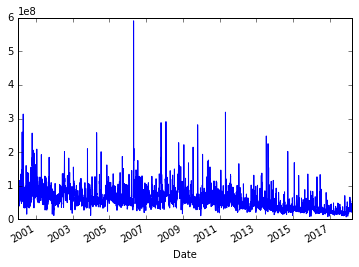

In [12]:
volume = df['Volume']
volume.plot();
plt.savefig('MSFT_Volume.png')

We split data into from `2000-01-01` to `2017-08-31` for training and from `2017-09-01` to `2018-03-31` for test.

In [13]:
# Separate data time stamps
def get_partial_index(df, start=None, end=None):
    if start is not None:
        df = df.loc[df.index >= start]
    if end is not None:
        df = df.loc[df.index <= end]
    return df.index

train_end = '2017-08-31'
test_start = '2017-09-01'
train_idx = get_partial_index(df, end=train_end)
test_idx = get_partial_index(df, start=test_start)


def generate_features(close, volume, label, timestamps, timelag):
    index = close.index
    data = []
    for i in range(1, timelag):
        # Normalize
        data.append(close.shift(i).values / close.values)
        data.append(volume.shift(i).values / volume.values)

    features = pd.DataFrame(np.stack(data, axis=1), index=index)
    features = features.loc[timestamps].dropna()
    label = label.dropna()
    time_idx = features.index & label.index
    y = label.loc[time_idx].values
    label_map = {-1: 0, 1: 1}
    y = np.array([label_map[y_i] for y_i in y]).astype(int)
    X = features.loc[time_idx].values
    return X, y


timelag = 30
train_X, train_y = generate_features(close, volume, labels['size'], train_idx, timelag=timelag)
test_X, test_y = generate_features(close, volume, labels['size'], test_idx, timelag=timelag)

Note that close and volume features are normalized with the current value [[3]](https://arxiv.org/pdf/1706.10059.pdf). Intuitively, the scales of close and volume themselves do not have any meanings. The value in comparison to the current close and value are rather essential information. This normalization allows you to build models irrelevant to the scales.

In [42]:
input_dim = train_X.shape[1]
output_dim = 1

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.fc3 = nn.Linear(8, output_dim)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def predict(self, x, threshold=.5):
        x = self.forward(x)
        x = F.sigmoid(x)
        return x > threshold

In [16]:
from torch_utils.datasets import NumpyDataset
from torch_utils.training import train_step, test_step

batch_size = 32
train_loader = tdata.DataLoader(NumpyDataset(train_X, train_y[:, None].astype(float)),
                                    batch_size=batch_size, shuffle=True)
test_loader = tdata.DataLoader(NumpyDataset(test_X, test_y[:, None].astype(float)),
                                   batch_size=batch_size)

In [17]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook

n_epochs = 1000
model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_func = F.binary_cross_entropy_with_logits
score_func = accuracy_score
for i in tqdm_notebook(range(n_epochs)):
    train_step(model, train_loader, optimizer,
               loss_func=loss_func, score_func=score_func,
               epoch=i, log_interval=0, silent=True)
    if i % 100 == 0:
        test_step(model, test_loader, loss_func=loss_func, score_func=score_func)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Test set
Average loss: 0.6605
Average Score: 0.6789


Test set
Average loss: 0.9798
Average Score: 0.4128


Test set
Average loss: 1.117
Average Score: 0.422


Test set
Average loss: 0.8126
Average Score: 0.5138


Test set
Average loss: 0.8917
Average Score: 0.4679


Test set
Average loss: 0.7815
Average Score: 0.5596


Test set
Average loss: 0.7882
Average Score: 0.5229


Test set
Average loss: 0.9028
Average Score: 0.5046


Test set
Average loss: 0.829
Average Score: 0.4954


Test set
Average loss: 0.769
Average Score: 0.5963




In [18]:
model.eval()
output = model.predict(torch.tensor(test_X).float())
accuracy = accuracy_score(test_y, output)
print(f'Test Accuracy: {accuracy:.4g}')

Test Accuracy: 0.5229


TADA! The resultant test accuracy is `0.5229`..... Ummmmmm......., this is no better than chance. One of the possible reasons for this is overfitting. We need to tweak the model architecture and way to train models. We can also consider that classification might be difficult for finance. Here is the explanation in the Quora [[4]](https://www.quora.com/Loss-cross-entropy-is-decreasing-but-accuracy-remains-the-same-while-training-convolutional-neural-networks-How-can-it-happen).
Even if model is able to learn the distribution, it might be difficult to predict the correct label under the noisy situation.

# Regression Approach

As we see previously, classification is difficult. It might make more sense to predict the price itself. We try to predict future returns based on the same input features as classification. We need to consider how many days future to look to define target returns.

To compare performances among different `num_day` parameters: `1, 2, 3, 4, 5, 10, 20`, we use free scale metrics `np.mean(np.abs(y_pred - y)) / np.std(y)`. Here is the result. 

In [19]:
def get_returns(close, timestamps=None, num_days=1):
    """Calculate num_days returns

    Parameters
    ----------
    close: pd.Series
        Close price series
    timestamps: pd.DatetimeIndex, optional
        sampled points to analyze
    num_days: int
        How many days to look forward

    Returns
    -------
    pd.Series: Future price normalized with current price
    """
    if timestamps is None:
        timestamps = close.index
    close = close.shift(-num_days) / close
    return close.loc[timestamps] - 1.

def generate_features(close, volume, num_days, timestamps, timelag):
    index = close.index
    data = []
    for i in range(1, timelag):
        # Normalize
        data.append(close.shift(i).values / close.values - 1.)
        data.append(volume.shift(i).values / volume.values - 1.)

    features = pd.DataFrame(np.stack(data, axis=1), index=index)
    features = features.loc[timestamps].dropna()
    label = get_returns(close, timestamps, num_days)
    label /= close
    label = label.dropna()
    time_idx = features.index & label.index
    y = label.loc[time_idx].values
    X = features.loc[time_idx].values
    return X, y

num_days = 5

timelag = 30
train_X, train_y = generate_features(close, volume, num_days, train_idx, timelag=timelag)
test_X, test_y = generate_features(close, volume, num_days, test_idx, timelag=timelag)

In [20]:
input_dim = train_X.shape[1]
output_dim = 1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.fc3 = nn.Linear(8, output_dim)
        
    def forward(self, x):
        if x.shape[0] == 1:
            self.eval()
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        self.train()
        return x
    
    def predict(self, x):
        x = self.forward(x).detach()
        return x

In [21]:
from torch_utils.datasets import NumpyDataset
from torch_utils.training import train_step, test_step

batch_size = 32
train_loader = tdata.DataLoader(NumpyDataset(train_X, train_y[:, None].astype(float)),
                                    batch_size=batch_size, shuffle=True)
test_loader = tdata.DataLoader(NumpyDataset(test_X, test_y[:, None].astype(float)),
                                   batch_size=batch_size)

In [26]:
def test_regression(num_days):

    timelag = 30
    train_X, train_y = generate_features(close, volume, num_days, train_idx, timelag=timelag)
    test_X, test_y = generate_features(close, volume, num_days, test_idx, timelag=timelag)

    batch_size = 32
    train_loader = tdata.DataLoader(NumpyDataset(train_X, train_y[:, None].astype(float)),
                                    batch_size=batch_size, shuffle=True)
    test_loader = tdata.DataLoader(NumpyDataset(test_X, test_y[:, None].astype(float)),
                                   batch_size=batch_size)

    n_epochs = 500
    model = Net()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_func = F.mse_loss
    score_func = None
    for i in tqdm_notebook(range(n_epochs)):
        train_step(model, train_loader, optimizer,
                   loss_func=loss_func, score_func=score_func,
                   epoch=i, log_interval=0, silent=True)
        if i % 100 == 0:
            test_step(model, test_loader, loss_func=loss_func, score_func=score_func)
        
    model.eval()
    output = model.predict(torch.tensor(test_X).float())
    plt.close()
    plt.title(f'Return Prediction {num_days}Days Forward')
    plt.plot(test_y, label='true', color='k')
    plt.plot(output[:, 0], label='prediction', color='b')
    plt.legend()
    plt.savefig(f'regression_{num_days}days.png')
    plt.close()
    return (output, test_y)

In [27]:
results = dict()
for num_days in [1, 2, 3, 4, 5, 10, 20]:
    result = test_regression(num_days)
    results[num_days] = result

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))


Test set
Average loss: 0.03645


Test set
Average loss: 1.395e-06


Test set
Average loss: 1.353e-07


Test set
Average loss: 1.218e-07


Test set
Average loss: 1.314e-07



HBox(children=(IntProgress(value=0, max=500), HTML(value='')))


Test set
Average loss: 0.05695


Test set
Average loss: 1.179e-06


Test set
Average loss: 9.122e-08


Test set
Average loss: 3.477e-07


Test set
Average loss: 2.82e-07



HBox(children=(IntProgress(value=0, max=500), HTML(value='')))


Test set
Average loss: 0.02603


Test set
Average loss: 2.849e-07


Test set
Average loss: 1.257e-07


Test set
Average loss: 1.649e-07


Test set
Average loss: 1.675e-07



HBox(children=(IntProgress(value=0, max=500), HTML(value='')))


Test set
Average loss: 0.08154


Test set
Average loss: 8.035e-06


Test set
Average loss: 4.311e-07


Test set
Average loss: 3.56e-07


Test set
Average loss: 4.064e-07



HBox(children=(IntProgress(value=0, max=500), HTML(value='')))


Test set
Average loss: 0.03974


Test set
Average loss: 1.19e-06


Test set
Average loss: 4.564e-07


Test set
Average loss: 1.803e-07


Test set
Average loss: 5.121e-07



HBox(children=(IntProgress(value=0, max=500), HTML(value='')))


Test set
Average loss: 0.133


Test set
Average loss: 7.541e-06


Test set
Average loss: 1.982e-06


Test set
Average loss: 1.049e-06


Test set
Average loss: 7.349e-07



HBox(children=(IntProgress(value=0, max=500), HTML(value='')))


Test set
Average loss: 0.05985


Test set
Average loss: 1.24e-05


Test set
Average loss: 1.346e-06


Test set
Average loss: 6.354e-07


Test set
Average loss: 8.009e-07



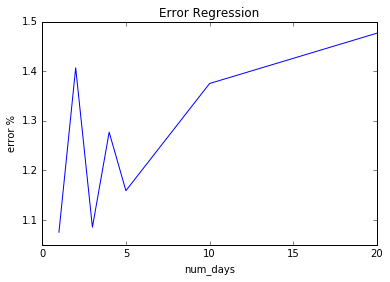

In [41]:
scores = []
num_days_list = []
for key in results.keys():
    pred, y = results[key]
    score = np.mean(np.abs(pred.numpy() - y)) / np.std(y)
    scores.append(score)
    num_days_list.append(key)
plt.title('Error Regression')
plt.plot(num_days_list, scores)
plt.ylabel('error %')
plt.xlabel('num_days')
plt.savefig('error_regression.png')

We do not see any specific relation between the length of days forward and performance. To find more reliable results, we need to validate model and tune hyperparameters.

# Wrap Up

The results we have seen in this article looks disappointed. We can mainly consider the following reasons:
1. The small number of data points
2. Require to tune model parameters

The first reason comes from the fact that the only single path is given and exactly the same pattern will never show up. Generally speaking, ML algorithms needs to see the similar patters from the same distribution for many times. Especially, when using Neural Network, a lot of data points are required.

In this article, I did not spend a lot of times on tuning model architectures. To tune parameters, we need to set up proper way to validate model performances, which will discuss in the future blog post. As one of the research direction, we can consider Bayesian approaches. Due to the noisy nature of financial data, Bayesian approaches help you avoid overfitting and give you more appropriate confidence levels of predictions. 

# References
* [1] [Advances in Financial Machine Learning](https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089)
* [2] [finance_ml](https://github.com/jjakimoto/finance_ml)

* [3] [A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem](https://arxiv.org/pdf/1706.10059.pdf)
* [4] [Loss (cross entropy) is decreasing but accuracy remains the same while training convolutional neural networks. How can it happen?](https://www.quora.com/Loss-cross-entropy-is-decreasing-but-accuracy-remains-the-same-while-training-convolutional-neural-networks-How-can-it-happen)